# Import Dataset dan Libraries

## Overview Dataset

Dataset ini merupakan dataset yang bertujuan untuk pembelajaran mengenai segmentasi pelanggan dengan menggunakan unsupervised learning.

Link dataset: https://drive.google.com/file/d/1jlHuVc9tFACJcj53QeCI330KoYTsj1W-/view?usp=drive_link

Informasi atribut dataset:

* CustomerID: Unique ID dari konsumen
* Gender: Gender dari konsumen
* Age: Umur dari konsumen
* Annual Income \(k\$\): Penghasilan tahunan konsumen \(\$\)
* Spending Score (1-100): Skor yang diberikan oleh mall berdasarkan kebiasaan belanja konsumen (1-100)


## EDA
Lakukan eksplorasi sederhana secara statistik pada dataset, beberapa fungsi hal yang krusial untuk diexplorasi:
* Statistik deskriptif dari dataset
* Informasi mengenai  dataset
* Hubungan antar variable

Jelaskan hasil eksplorasi pada notebook!

In [117]:
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
%matplotlib inline
from sklearn.cluster import KMeans

In [118]:
##LOAD DATA
filename = 'Mall_Customers.csv'

#Read csv
df = pd.read_csv(filename)
print ("Shape of dataset: ", df.shape)

df.head(5)

Shape of dataset:  (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Text(0.5, 1.0, 'Penyebaran data')

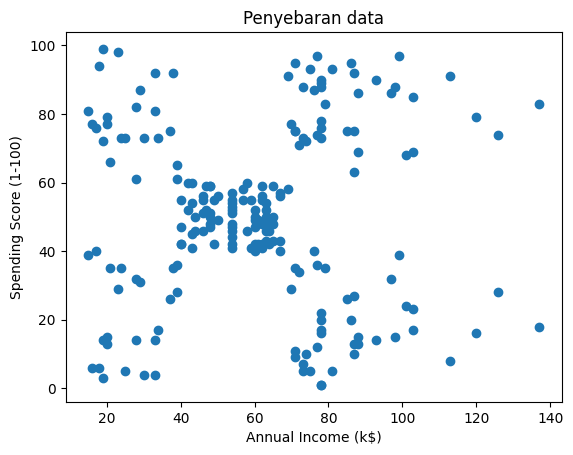

In [120]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
y.head()
plt.scatter(x, y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Penyebaran data')


#plt.scatter(df[:, 0], df[:, 2], marker='o')

# Penjelasan statistik
dari visualisasi diatas terdapat 5 tumpukan data yang menyebar. maka dapat diasumsikan bahwa data ini cocok untuk dicluster kedalam 5 cluster

# EDA & Data Preprocessing


## Lakukan Data Preprocessing
Data preprocessing dilakukan untuk menghasilkan dataset yang lebih bersih, lebih akurat, dan lebih konsisten. Lakukan data preprocessing dengan bantuan beberapa fungsi yang krusial berikut:
* isnull
* duplicated

Anda diperbolehkan untuk melakukan preprocessing dengan fungsi lainnya.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [122]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [123]:
df.duplicated().any()

False

In [124]:
df['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [125]:
df = df.replace(['Female','Male'],['0','1'])

In [126]:
df['Gender'].value_counts()

0    112
1     88
Name: Gender, dtype: int64

In [127]:
df[[ 'Gender']] = df[['Gender']].apply(pd.to_numeric, errors='coerce')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [129]:
df_feature_selection = df[['Gender','Age','Annual Income (k$)',  'Spending Score (1-100)']]

# PCA
PCA merupakan salah satu cara untuk melakukan transformasi pada sebuah fitur dengan melakukan pengurangan jumlah fitur dalam dataset sambil mempertahankan sebanyak mungkin informasi (variansi) dari data asli. Untuk mengetahui dampak PCA terhadap fitur pada data, lakukan beberapa hal ini:
* Lakukan Principal Component Analysis (PCA) pada data.
* Tentukan rasio variansi yang dijelaskan oleh beberapa komponen utama pertama.
* Hitung jumlah kumulatif dari rasio variansi yang dijelaskan oleh komponen-komponen utama tersebut.
* Buatlah visualisasi berikut:
  * Gunakan bar plot untuk menampilkan rasio variansi yang dijelaskan oleh masing-masing komponen utama.
  * Gunakan step plot untuk menampilkan jumlah kumulatif variansi yang dijelaskan oleh komponen-komponen utama.
* Tentukan apakah PCA perlu dilakukan sebagai tahapan dalam proses clustering ini? Berikan alasannya!

In [130]:
#NORMALISASI
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_feature_selection_t = scaler.fit_transform(df_feature_selection)
df_feature_selection_t[0:5]

array([[ 1.12815215, -1.42456879, -1.73899919, -0.43480148],
       [ 1.12815215, -1.28103541, -1.73899919,  1.19570407],
       [-0.88640526, -1.3528021 , -1.70082976, -1.71591298],
       [-0.88640526, -1.13750203, -1.70082976,  1.04041783],
       [-0.88640526, -0.56336851, -1.66266033, -0.39597992]])

In [131]:
df_feature_selection_t = pd.DataFrame(df_feature_selection_t, columns=['Gender', 'Age','Annual Income (k$)','Spending Score (1-100)'])
df_feature_selection_t.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


In [132]:
df_feature_selection_t = df_feature_selection_t.drop(columns=['Gender'])


atribut gender tidak termasuk karena tidak ada korelasi antara atribut lainnya. dan atribut ini menyebar diseluruh data

In [133]:
df_feature_selection_t

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [134]:
# Mengaplikasikan PCA
pca = PCA()
pca.fit(df_feature_selection_t)

PCA()

In [135]:
# Tentukan jumlah principal component yang optimal
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

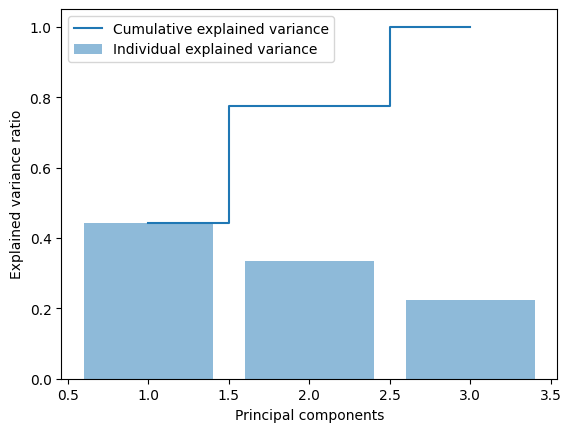

In [136]:
# Tampilkan visualisasi dari hasil PCA dengan warna yang berbeda untuk masing-masing principal component
plt.bar(range(1, len(cum_var_exp)+1), var_exp, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.show()

GAMBAR DIATAS DAPAT DILIHAT LINE CHART GABUNGAN ANTARA KE 2 VARIALBEL BERADA SEKITAR 80 % ATAU 0,8. Namun PADA FEATURE KE 3 TERDAPAT VARIANCE RATIO SEBANYAK 30 % DAN LEBIH TINGGI DARI FEATURE KE 2. MAKA KETIGA DARI ATRIBUT DIATAS AKAN TETAP DIGUNAKAN.

PCA PERLU DILAKUKAN UNTUK MENGHEMAT WAKTU DALAM TRAINING DATA

In [137]:
#FEATURE SELECTION
df_feat = df[['Age','Annual Income (k$)', 'Spending Score (1-100)']]
df_feat_4 = df[['Gender','Age','Annual Income (k$)', 'Spending Score (1-100)']]
df_feat.head(2)

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81


# Modeling
Dalam rangka segmentasi pelanggan menggunakan clustering, pilihlah katergori yang anda pertimbangkan mampu merepresentasikan cluster dari pelanggan dengan baik. Harapannya ada beberapa algoritma yang untuk digunakan, yaitu:


## Algoritma K-Means
Tahapan:
* Dikarenakan K-Means sensitif terhadap jarak antara titik-titik data maka lakukan penskalaan data menggunakan StandardScaler sehingga hasil clustering menjadi lebih optimal.
* Gunakan metode "elbow" untuk memutuskan jumlah cluster yang optimal.
* Lakukan clustering dengan K-Means dengan tiga variasi jumlah cluster berbeda, saran variasi: k-1 optimal, k optimal, dan k+1 optimal
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

In [138]:
#NORMALISASI PADA 3 ATRIBUT
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_feat_t = scaler.fit_transform(df_feat)
df_feat_t[0:5]

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

In [139]:
#NORMALISASI PADA SELURUH ATRIBUT
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_feat_t_4 = scaler.fit_transform(df_feat_4)
df_feat_t_4[0:5]

array([[ 1.12815215, -1.42456879, -1.73899919, -0.43480148],
       [ 1.12815215, -1.28103541, -1.73899919,  1.19570407],
       [-0.88640526, -1.3528021 , -1.70082976, -1.71591298],
       [-0.88640526, -1.13750203, -1.70082976,  1.04041783],
       [-0.88640526, -0.56336851, -1.66266033, -0.39597992]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

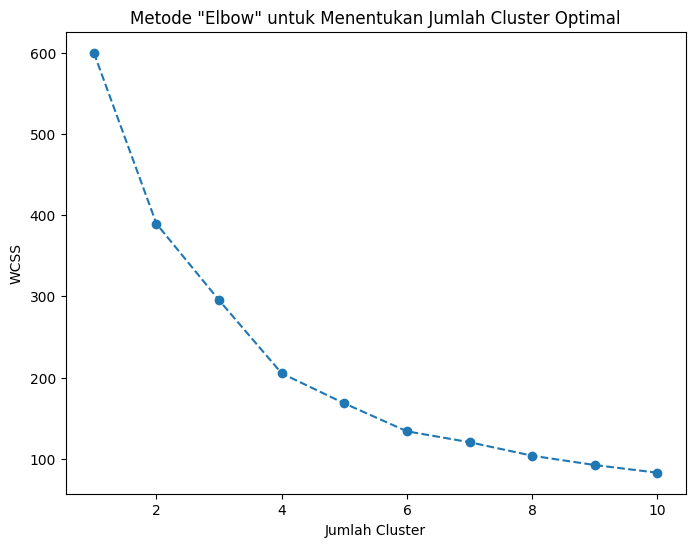

In [140]:
##ELBOW METHOD

# Menggunakan metode "elbow" untuk menentukan jumlah cluster optimal
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):  # Coba jumlah cluster dari 1 hingga 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_feat_t)
    wcss.append(kmeans.inertia_)

# Visualisasi metode "elbow"
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Metode "Elbow" untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.show()

dari gambar diatas cluster yang optimal adalah 4 yang paling optimal karna berbentuk siku.
namun akan dilakukan percobaan untuk 2 klaster sampai 7

# MODELING DENGAN 3 FEATURE DENGAN PCA

In [141]:
clusterNum = 2
k_means2 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means2.fit(df_feat_t)
df_feat['kmeans_2'] = k_means2.labels_

<ipython-input-141-d003ab234622>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_2'])


0.33547192894004574

In [143]:
clusterNum = 3
k_means3 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means3.fit(df_feat_t)
df_feat['kmeans_3'] = k_means3.labels_

In [144]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_3'])

0.357793388710272

In [145]:
clusterNum = 4
k_means4 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means4.fit(df_feat_t)
df_feat['kmeans_4'] = k_means4.labels_

In [146]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_4'])

0.4039582785148566

In [147]:
clusterNum = 5
k_means5 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means5.fit(df_feat_t)
df_feat['kmeans_5'] = k_means5.labels_

In [148]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_5'])

0.41664341513732767

In [149]:
clusterNum = 6
k_means6 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means6.fit(df_feat_t)
df_feat['kmeans_6'] = k_means6.labels_

In [150]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_6'])

0.42742814991580175

In [151]:
clusterNum = 7
k_means7 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means7.fit(df_feat_t)
df_feat['kmeans_7'] = k_means7.labels_

In [152]:
#SCORE SILHOUTE
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t, df_feat['kmeans_7'])

0.4151092070320817

In [153]:
df_feat.head()

,Age,Annual Income (k$),Spending Score (1-100),kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7
0,19,15,39,1,1,3,3,3,5
1,21,15,81,1,1,3,3,3,5
2,20,16,6,0,1,3,2,0,4
3,23,16,77,1,1,3,3,3,5
4,31,17,40,1,1,3,3,0,4


In [154]:
import plotly.express as px

fig = px.scatter(x=df_feat['Annual Income (k$)'], y=df_feat['Spending Score (1-100)'], color=df_feat['kmeans_6'])
fig.show()

Dari hasil evaluasi terjadi overlapping. namun setelah dilakukan percobaan pada semua model, model6 dengan menggunakan jumlah klaster = 6 dan 3 feature lebih baik dari model lainnya dengan score 0.4274

In [156]:
#CENTROID AKHIR
k_means_cluster_centers = k_means6.cluster_centers_
k_means_cluster_centers

array([[ 0.47895722, -1.30822992, -1.19644353],
       [ 1.25472096, -0.24021294, -0.04399777],
       [-0.44191719,  0.99158305,  1.23950275],
       [-0.97602698, -1.32549704,  1.0371827 ],
       [-0.87309844, -0.11378508, -0.09358039],
       [ 0.22171558,  1.08322527, -1.29005223]])

In [157]:
df_feat.head(3)

,Age,Annual Income (k$),Spending Score (1-100),kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7
0,19,15,39,1,1,3,3,3,5
1,21,15,81,1,1,3,3,3,5
2,20,16,6,0,1,3,2,0,4


# MODELING DENGAN 4 FEATURE TANPA DILAKUKAN PCA

In [158]:
clusterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df_feat_t_4)
df_feat_4['kmeans_2_4'] = k_means.labels_

In [159]:
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t_4, df_feat_4['kmeans_2_4'])

0.2518152915788437

In [160]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df_feat_t_4)
df_feat_4['kmeans_3_4'] = k_means.labels_

In [161]:
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t_4, df_feat_4['kmeans_3_4'])

0.26188419594665274

In [162]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df_feat_t_4)
df_feat_4['kmeans_4_4'] = k_means.labels_

In [163]:
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t_4, df_feat_4['kmeans_4_4'])

0.3016237438985174

In [164]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df_feat_t_4)
df_feat_4['kmeans_5_4'] = k_means.labels_

In [165]:
from sklearn.metrics import silhouette_score as ss
ss(df_feat_t_4, df_feat_4['kmeans_5_4'])

0.31606517761091896

In [166]:
df_feat_4.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100),kmeans_2_4,kmeans_3_4,kmeans_4_4,kmeans_5_4
0,1,19,15,39,1,1,3,1
1,1,21,15,81,1,1,3,1
2,0,20,16,6,0,0,1,3


#KESIMPULAN KMEANS

DARI SEMUA MODEL YANG SUDAH DICOBA DIDAPATKAN HASIL SCORE TERBAIK ADALAH DENGAN MENGGUNAKAN SELECTION FEATURE PCA. HASIL TERBAIK YAITU DENGAN 3 FETAURE DAN N_CLUSTER= 6. DIDAPATKAN SCORE SILHOUTE = 0,468. Namun terdapat kekurangan dalam model ini yaitu terjadinya overlapping.


## Algoritma Agglomerative Hierarchical Clustering
Tahapan:
* Lakukan data preprocessing sehingga bisa dilakukan clustering dengan algortima hierarchical.
* Buat dendogram dari dataset untuk menentukan jumlah klaster yang optimal dan buat tiga variasi nilai k, saran variasi: klaster-1 optimal, klaster optimal, dan klaster+1 optimal
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

In [167]:
df_feat_hirarki = df[['Age','Annual Income (k$)','Spending Score (1-100)']]

In [168]:
df_feat_hirarki.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [169]:
#NORMALISASI
from sklearn.preprocessing import MinMaxScaler
x = df_feat_hirarki.values #returns a numpy array
min_max_scaler = MinMaxScaler()
df_feat_hirarki_t = min_max_scaler.fit_transform(x)
df_feat_hirarki_t [0:5]

array([[0.01923077, 0.        , 0.3877551 ],
       [0.05769231, 0.        , 0.81632653],
       [0.03846154, 0.00819672, 0.05102041],
       [0.09615385, 0.00819672, 0.7755102 ],
       [0.25      , 0.01639344, 0.39795918]])

In [170]:
#CLUSTERING USING EUCLIDIEN DISTANCE

from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(df_feat_hirarki_t,df_feat_hirarki_t)
print(dist_matrix)

[[0.         0.43029381 0.33738296 ... 1.00888686 1.0528145  1.11639204]
 [0.43029381 0.         0.76559158 ... 0.93683095 1.20748243 1.01507247]
 [0.33738296 0.76559158 0.         ... 1.16089362 1.02563246 1.27984489]
 ...
 [1.00888686 0.93683095 1.16089362 ... 0.         0.57849818 0.13432353]
 [1.0528145  1.20748243 1.02563246 ... 0.57849818 0.         0.66437953]
 [1.11639204 1.01507247 1.27984489 ... 0.13432353 0.66437953 0.        ]]


#Menggunakan Linkage Complete

<ipython-input-171-c93043a81965>:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



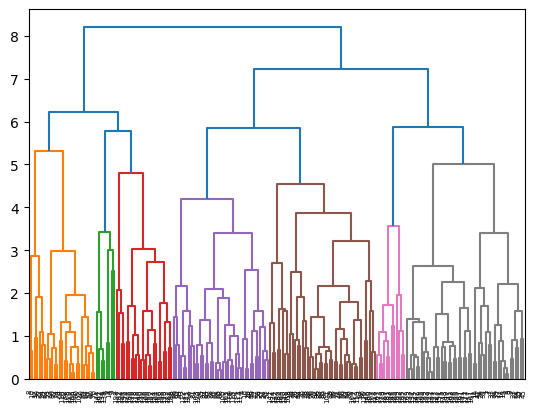

In [171]:
complete = hierarchy.linkage(dist_matrix, 'complete')
dendro_comp = hierarchy.dendrogram(complete)

n_cluster optimal dari visualisasi di atas adalah 7

In [172]:
##TESTING dengan n_cluster = 5

agglom = AgglomerativeClustering(n_clusters = 5, linkage = 'complete')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_5'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

<ipython-input-172-e6d65660d6a2>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_5'])

0.22703517721460678

In [174]:
##TESTING dengan n_cluster = 6

agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_6'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [175]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_6'])

0.2507377813698712

In [176]:
##TESTING dengan n_cluster = 7

agglom = AgglomerativeClustering(n_clusters = 7, linkage = 'complete')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_7'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [177]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_7'])

0.26166557570616006

In [178]:
##TESTING dengan n_cluster = 8

agglom = AgglomerativeClustering(n_clusters = 8, linkage = 'complete')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_8'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [179]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_8'])

0.2708746050330789

In [180]:
df_feat_hirarki.head()

,Age,Annual Income (k$),Spending Score (1-100),kmeans_5,kmeans_6,kmeans_7,kmeans_8
0,19,15,39,1,0,6,6
1,21,15,81,2,2,2,0
2,20,16,6,1,0,6,6
3,23,16,77,2,2,2,0
4,31,17,40,0,5,5,2


#Menggunakan Linkage Average

<ipython-input-181-28113871fea4>:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



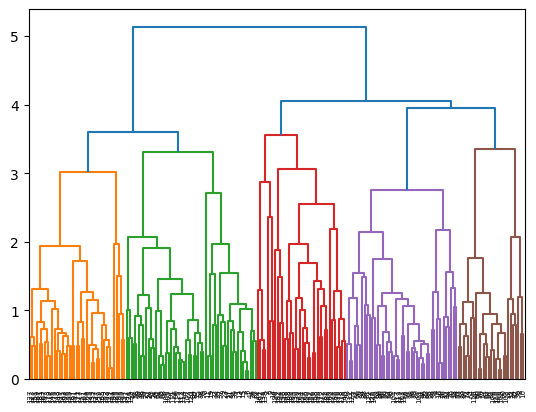

In [181]:
average = hierarchy.linkage(dist_matrix, 'average')
dendro_avg = hierarchy.dendrogram(average)

In [182]:
##TESTING dengan n_cluster = 4

agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'average')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_avg_4'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [183]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_avg_4'])

0.34169507492884515

In [184]:
##TESTING dengan n_cluster = 5

agglom = AgglomerativeClustering(n_clusters = 5, linkage = 'average')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_avg_5'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [185]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_avg_5'])

0.35917057572391475

In [186]:
##TESTING dengan n_cluster = 6

agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'average')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_avg_6'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [187]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_avg_6'])

0.35965051977068035

In [188]:
##TESTING dengan n_cluster = 7

agglom = AgglomerativeClustering(n_clusters = 7, linkage = 'average')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_avg_7'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [189]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_avg_7'])

0.36477875536332116

In [190]:
##TESTING dengan n_cluster = 8

agglom = AgglomerativeClustering(n_clusters = 8, linkage = 'average')
agglom.fit(dist_matrix)

df_feat_hirarki['kmeans_avg_8'] = agglom.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [191]:
from sklearn.metrics import silhouette_score as ss
ss(dist_matrix, df_feat_hirarki['kmeans_avg_8'])

0.3965943955447762

In [192]:
df_feat_hirarki.head()

,Age,Annual Income (k$),Spending Score (1-100),kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_avg_4,kmeans_avg_5,kmeans_avg_6,kmeans_avg_7,kmeans_avg_8
0,19,15,39,1,0,6,6,0,2,2,0,4
1,21,15,81,2,2,2,0,0,2,2,0,4
2,20,16,6,1,0,6,6,2,0,5,2,2
3,23,16,77,2,2,2,0,0,2,2,0,4
4,31,17,40,0,5,5,2,3,3,3,3,3


# Kesimpulan Hirarki Klastering

Dilakukan uji coba terhadap linkage complete dan average. Hasil modeling menggunakan linkage average lebih baik dibanding menggunakan linkage complete. Score tertinggi adalah 0.39 dengan 8 klaster.


## Algoritma DBSCAN (Bonus)
Tahapan:
* Lakukan data preprocessing sehingga bisa dilakukan clustering dengan algortima DBSCAN.
* Lakukan clustering dengan nilai eps dengan tiga variasi jumlah cluster berbeda
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

In [193]:
df_feat_dbscan = df[['Age','Annual Income (k$)', 'Spending Score (1-100)']]

In [194]:
#NORMALISASI PADA 3 ATRIBUT
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_feat_dbscan_t = scaler.fit_transform(df_feat_dbscan)
df_feat_dbscan_t [0:5]

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

In [195]:
##GUNAKAN GRID SEARCH

epsilons = np.linspace(0.01, 1, num = 15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [196]:
min_samples = np.arange(2, 20, step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [197]:
import itertools

combinations = list(itertools.product(epsilons, min_samples))

In [198]:
n=len(combinations)
n

90

In [199]:
from sklearn.cluster import DBSCAN

In [200]:
def get_scores_and_labels(combinations, X):
    scores=[]
    all_labels_list = []
    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters<2) or (num_clusters> 11):
            scores.append(-10)
            all_labels_list.append('bad')
            c = (eps, num_samples)
            print(f"Kombinasi dalam iterasi {i+1} of {n} mempunyai {num_clusters} clusters. Moving on")
            continue
        scores.append(ss(X, labels))
        all_labels_list.append(labels)
        print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, Num Cluster : {num_clusters}")
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]

    return {'best_epsilon':best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}
best_dict = get_scores_and_labels(combinations, df_feat_dbscan_t)

Kombinasi dalam iterasi 1 of 90 mempunyai 0 clusters. Moving on
Kombinasi dalam iterasi 2 of 90 mempunyai 0 clusters. Moving on
Kombinasi dalam iterasi 3 of 90 mempunyai 0 clusters. Moving on
Kombinasi dalam iterasi 4 of 90 mempunyai 0 clusters. Moving on
Kombinasi dalam iterasi 5 of 90 mempunyai 0 clusters. Moving on
Kombinasi dalam iterasi 6 of 90 mempunyai 0 clusters. Moving on
Index: 6, Score: -0.3675756110129569, Labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

In [201]:
best_dict

{'best_epsilon': 0.6464285714285715,
 'best_min_samples': 14,
 'best_labels': array([-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,
         0, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0,
        -1,  0, -1,  0, -1,  0, -1,  0,  1,  2,  1,  2,  1,  2,  2,  2,  1,
         2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  2,  1,  1,
         2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  2,
         1,  1,  2,  2,  1,  1,  2,  1,  1,  2,  2,  1,  2,  1,  2,  2,  1,
         1,  2,  1,  2,  1,  1,  1,  1,  1,  2, -1,  2,  2,  2,  1,  1,  1,
         1,  2, -1, -1,  3,  2,  3,  1,  3, -1,  3, -1,  3,  2,  3, -1,  3,
        -1,  3, -1,  3, -1,  3,  2,  3, -1,  3,  1,  3, -1,  3, -1,  3, -1,
         3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3,
        -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,  3, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 'best_score': 0.28472185

In [202]:
df_feat_dbscan['kmeans_dbscan'] = best_dict['best_labels']
df_feat_dbscan['kmeans_dbscan'].value_counts()

<ipython-input-202-c6d0073b9bb8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-1    67
 1    50
 2    33
 3    32
 0    18
Name: kmeans_dbscan, dtype: int64

In [203]:
df_feat_dbscan.head()

,Age,Annual Income (k$),Spending Score (1-100),kmeans_dbscan
0,19,15,39,-1
1,21,15,81,0
2,20,16,6,-1
3,23,16,77,0
4,31,17,40,-1


In [204]:
from sklearn.metrics import silhouette_score as ss
ss(df_feat_dbscan_t, df_feat_dbscan['kmeans_dbscan'])

0.2847218569718596

In [205]:
x= df_feat_dbscan['Annual Income (k$)']
y= df_feat_dbscan['Spending Score (1-100)']
fig = px.scatter(x=x, y=y, color=df_feat_dbscan['kmeans_dbscan'])
fig.show()

# Evaluation

Algoritma DBSCAN menggunakan hyperparameter epsilon 0.01 sampai 1, dan number_sumples = 2 sampai 20. Dilakukan grid search untuk menemukan parameter terbaik dengan 90 kombinasi. Parameter terbaik adalah best_epsilon : 0.646, min_samples: 14, best_score_silhoute: 0.2847218569718596. Hasil jumlah klastering yang didapatkan adalah 5 cluster.

## Penjelasan Metrik  

Dalam praktikum ini, kita akan menggunakan Silhouette Coefficient atau Silhouette Score untuk menghitung performa dari clustering. Silhouette Coefficient merupakan salah satu metrik yang digunakan untuk menghitung performa cluster pada dataset yang tidak memiliki ground truth label. Metrik ini menghitung score relatif setiap cluster dengan cluster lainnya dengan rentang nilai -1 - 1, dimana:

* 1: Berarti cluster jelas terpisah satu sama lain dan dapat dibedakan dengan jelas.
* 0: Berarti cluster tidak menunjukkan perbedaan, atau bisa dikatakan bahwa jarak antar cluster tidak signifikan.
* -1: Berarti cluster ditempatkan dengan cara yang salah.


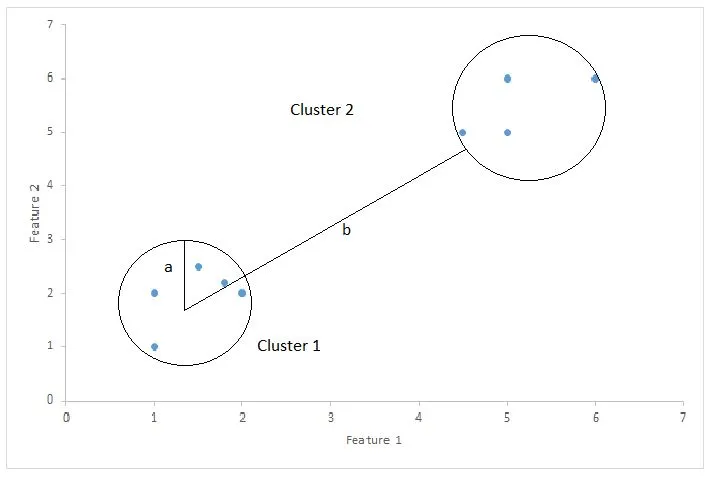

Untuk menghitung score satu cluster ke cluster lainnya adalah sebagai berikut:

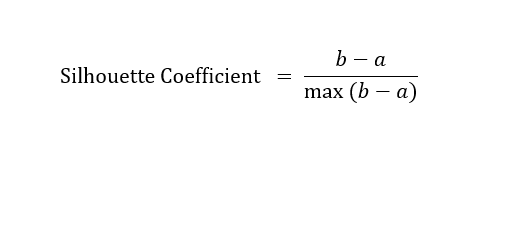

di mana

a = jarak rata-rata intra-clluster yaitu jarak rata-rata antara setiap titik dalam sebuah cluster.

b = jarak rata-rata antar-cluster yaitu jarak rata-rata antara semua cluster.

## Clustering Evaluation

Lakukan beberapa evaluasi terhadap hasil clustering menggunakan Silhoutte Coefficient, adapun evaluasi yang harus dijelaskan pada praktikum ini:
1. Penjelasan mengenai variasi terbaik dari clustering menggunakan K-means dan alasan variasi ini lebih baik daripada variasi lainnya.
2. Penjelasan variasi terbaik dari clustering menggunakan Hierarchical Clustering dan alasan variasi ini lebih baik daripada variasi lainnya.
3. Penjelasan variasi terbaik dari clustering menggunakan DBSCAN dan alasan variasi ini lebih baik daripada variasi lainnya (Bonus).
4. Penjelasan algortima terbaik dari untuk melakukan clustering dan dan alasan algoritma ini lebih baik daripada algoritma lainnya.

# HASIL EVALUASI
1. DARI SEMUA MODEL YANG SUDAH DICOBA DIDAPATKAN HASIL SCORE TERBAIK ADALAH DENGAN MENGGUNAKAN SELECTION FEATURE PCA. HASIL TERBAIK YAITU DENGAN 3 FETAURE DAN N_CLUSTER= 6. DIDAPATKAN SCORE SILHOUTE = 0,468. NAMUN TERDAPAT KEKURANGAN DALAM MODEL INI YAITU TERJADI OVERLAPPING.
2. DILAKUKAN UJI COBA TERHADAP LINKAGE COMPLETE DAN AVERAGE. HASIL MODELING MENGGUNAKAN LINKAGE AVERAGE LEBIH BAIK DIBANDING MENGGUNAKAN LINKAGE COMPLETE. SCORE TERTINGGI ADALAH 0.39 DENGAN 8 KLASTER.
3. ALGPRTIMA DBSCAN MENGGUNAKAN HYPERPARAMETER EPSOLON 0.01 SAMPAI DENGAN 1, DAN NUMBER_SUMPLES = 2 SAMPAI 20. DILAKUKAN GRID SEARCH UNTUK MENEMUKAN PARAMETER TERBAIK DARI 90 KOMBINASI. PARAMETER TERBAIK ADALAH EPSILON = 0.646, NUM_SUMPLES = 14, DAN BEST SCORE SILHOUTE = 0,284721. HASIL KLASTERING YANG DIDAPATKAN ADALAH 5 CLUSTER.
4. ALGORITMA TERBAIK DARI SELURUH MODEL YANG SUDAH DICOBA ADALAH ALGORITMA K-MEANS DENGAN JUMLAH N_CLUSTER = 6 DAN BEST SCORE SILHOUTE = 0,468.

# Labelling Dataset

Dikarenakan dataset yang digunakan pada praktikum ini tidak memiliki ground truth label, maka pada tahapan ini anda diminta untuk membuat file .csv dari model cluster terbaik yang dijelaskan pada bagian clustering evaluation, adapun atribut dari data .csv tersebut adalah:
* CustomerID: Unique ID dari konsumen
* Gender: Gender dari konsumen
* Age: Umur dari konsumen
* Annual Income \(k\$\): Penghasilan tahunan konsumen \(\$\)
* Spending Score (1-100): Skor yang diberikan oleh mall berdasarkan kebiasaan belanja konsumen (1-100)
* cluster_label: Label hasil clustering (0,1, ..., N)


In [206]:
df['Gender'] = df['Gender'].astype(str)
df = df.replace(['0','1'],['Female','Male'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [207]:
df['cluster_label'] = k_means6.labels_

In [208]:
df['cluster_label'].value_counts()

1    45
2    39
4    38
5    33
3    24
0    21
Name: cluster_label, dtype: int64

In [209]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_label
0,1,Male,19,15,39,3
1,2,Male,21,15,81,3
2,3,Female,20,16,6,0
3,4,Female,23,16,77,3
4,5,Female,31,17,40,0


In [210]:
df.to_csv('data.csv', index=False)